In [13]:
import pandas as pd
import numpy as np
import math



# Preprocess
#from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler



# Visullize
import matplotlib.pyplot as plt
#import seaborn as sns

# Modeling
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

# Others
import warnings
warnings.simplefilter("ignore")
from IPython.display import display, HTML


np.set_printoptions(precision=8, suppress=True)
np.set_printoptions(precision=8, suppress=True, floatmode='fixed')

%precision 8

'%.8f'

In [189]:
# Dataset path
#data_path = Path('C:/Users/pxs220058/Downloads/sem 2/ML/Project/optiver-realized-volatility-prediction/')
INPUT_DIR = 'C:/Users/pxs220058/Downloads/sem 2/ML/Project/optiver-realized-volatility-prediction/'

# setting display option
pd.options.display.max_columns = 50

In [110]:
#　Log Return
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

# Realized Volatility
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

# WAP calculation
def wap_calculation1(df):
    return (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])

def wap_calculation2(df):
    return (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])

# RMSPE
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

In [7]:

# read data
#df = pd.read_parquet(data_path / f'book_{data_type}.parquet/stock_id=0/')

df_book = pd.read_parquet(INPUT_DIR + 'book_train.parquet')

df_book

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
...,...,...,...,...,...,...,...,...,...,...,...
12899260,32767,581,0.997219,0.997867,0.997165,0.997921,225,2,20,45,9
12899261,32767,582,0.997219,0.997867,0.997165,0.997921,225,1,20,45,9
12899262,32767,588,0.997219,0.997921,0.997165,0.997975,225,45,20,1,9
12899263,32767,595,0.997219,0.997651,0.997165,0.997921,225,1,20,45,9


In [194]:
# set stock_id
#df['stock_id'] = stock_id

# WAP calculation
df_book['wap1'] = wap_calculation1(df_book)
df_book['wap2'] = wap_calculation2(df_book)

# log return calculation
df_book['log_return1'] = df_book.groupby(['time_id'])['wap1'].apply(log_return).fillna(0)
df_book['log_return2'] = df_book.groupby(['time_id'])['wap2'].apply(log_return).fillna(0) 

df_book['wap_diff_1_2'] = abs(df_book['wap1'] - df_book['wap2'])
df_book['bid_spread'] = abs(df_book['bid_price1'] - df_book['bid_price2'])
df_book['ask_spread'] = abs(df_book['ask_price1'] - df_book['ask_price2'])
df_book['bid_ask_spread'] = abs(df_book['ask_price1'] / df_book['bid_price1'])-1
df_book['ba_spread_ratio'] = abs(df_book['ask_spread'] / df_book['bid_spread'])

# Log_return calculation each stock_id and time_id
#df_book_realized_vol_per_stock = pd.DataFrame(df_book.groupby(['stock_id','time_id'])[['log_return1','log_return2']].agg(realized_volatility)).reset_index()

# Define a dictionary to specify aggregation functions for each column
agg_dict = {
    'log_return1': realized_volatility,
    'log_return2': realized_volatility,
    'wap_diff_1_2': 'mean',     
    'bid_ask_spread': 'mean',
    'bid_spread': 'mean',
    'ask_spread': 'mean',
    'ba_spread_ratio': 'mean'
}

# Group by 'stock_id' and 'time_id', then apply the aggregation functions
df_book_realized_vol_per_stock = (
    df_book.groupby(['stock_id', 'time_id'])
    .agg(agg_dict)
    .reset_index()
)


df_book_realized_vol_per_stock

,stock_id,time_id,log_return1,log_return2,wap_diff_1_2,bid_ask_spread,bid_spread,ask_spread,ba_spread_ratio
0,0,5,0.004499,0.006999,0.000388,0.000852,0.000176,0.000151,1.556010
1,0,11,0.001204,0.002476,0.000212,0.000394,0.000142,0.000135,1.788847
2,0,16,0.002369,0.004801,0.000331,0.000725,0.000197,0.000198,2.421176
3,0,31,0.002574,0.003637,0.000380,0.000861,0.000190,0.000108,1.445631
4,0,62,0.001894,0.003257,0.000254,0.000397,0.000191,0.000109,0.680590
...,...,...,...,...,...,...,...,...,...
38295,9,32751,0.005344,0.007541,0.000482,0.000996,0.000183,0.000177,2.079240
38296,9,32753,0.003768,0.004097,0.000307,0.000904,0.000118,0.000126,1.937813
38297,9,32758,0.003223,0.007377,0.000514,0.001017,0.000174,0.000459,5.917637
38298,9,32763,0.004849,0.006573,0.000239,0.000476,0.000129,0.000136,1.606615


In [195]:
df_trade = pd.read_parquet(INPUT_DIR + 'trade_train.parquet')
    
df_trade = df_trade.sort_values(by=['time_id', 'seconds_in_bucket']).reset_index(drop=True)
    

# log return calculation
df_trade['trade_log_return1'] = df_trade.groupby(by = ['time_id'])['price'].apply(log_return).fillna(0)
df_trade_og = df_trade    
# Log_return calculation each stock_id and time_id
df_trade = pd.DataFrame(df_trade.groupby(['stock_id','time_id'])[['trade_log_return1']].agg(realized_volatility).reset_index())
df_trade
df_trade_og

,time_id,seconds_in_bucket,price,size,order_count,stock_id,trade_log_return1
0,5,0,1.000688,101,2,2,0.000000
1,5,0,0.999172,1,1,8,-0.001516
2,5,2,0.999987,108,2,3,0.000815
3,5,5,1.000607,3,2,2,0.000620
4,5,5,1.002494,116,8,6,0.001883
...,...,...,...,...,...,...,...
2546491,32767,596,1.000000,105,2,3,0.000136
2546492,32767,596,0.997956,200,1,6,-0.002047
2546493,32767,596,0.999914,2,1,8,0.001960
2546494,32767,596,0.997455,11,2,9,-0.002462


In [196]:
train_df = pd.read_csv(INPUT_DIR + 'train.csv')
train_df['row_id'] = train_df['stock_id'].astype(str) + '-' + train_df['time_id'].astype(str)
display(train_df.head())

,stock_id,time_id,target,row_id
0,0,5,0.004136,0-5
1,0,11,0.001445,0-11
2,0,16,0.002168,0-16
3,0,31,0.002195,0-31
4,0,62,0.001747,0-62


In [197]:
df = df_book_realized_vol_per_stock.merge(df_trade, on=['stock_id', 'time_id'], how='left').fillna(-999)
df = df.merge(train_df, on=['stock_id', 'time_id'], how='left').fillna(-999)

df

,stock_id,time_id,log_return1,log_return2,wap_diff_1_2,bid_ask_spread,bid_spread,ask_spread,ba_spread_ratio,trade_log_return1,target,row_id
0,0,5,0.004499,0.006999,0.000388,0.000852,0.000176,0.000151,1.556010,0.018342,0.004136,0-5
1,0,11,0.001204,0.002476,0.000212,0.000394,0.000142,0.000135,1.788847,0.013301,0.001445,0-11
2,0,16,0.002369,0.004801,0.000331,0.000725,0.000197,0.000198,2.421176,0.012161,0.002168,0-16
3,0,31,0.002574,0.003637,0.000380,0.000861,0.000190,0.000108,1.445631,0.006728,0.002195,0-31
4,0,62,0.001894,0.003257,0.000254,0.000397,0.000191,0.000109,0.680590,0.008359,0.001747,0-62
...,...,...,...,...,...,...,...,...,...,...,...,...
38295,9,32751,0.005344,0.007541,0.000482,0.000996,0.000183,0.000177,2.079240,0.010985,0.006234,9-32751
38296,9,32753,0.003768,0.004097,0.000307,0.000904,0.000118,0.000126,1.937813,0.013394,0.002501,9-32753
38297,9,32758,0.003223,0.007377,0.000514,0.001017,0.000174,0.000459,5.917637,0.003399,0.003578,9-32758
38298,9,32763,0.004849,0.006573,0.000239,0.000476,0.000129,0.000136,1.606615,0.019301,0.004607,9-32763


In [198]:
# Sort the DataFrame by stock_id and time_id
df.sort_values(['stock_id', 'time_id'], inplace=True)

split_percent = 0.7

# Calculate the % threshold for each stock
stock_thresholds = df.groupby('stock_id').time_id.transform(lambda x: x.quantile(split_percent))

# Create a 'bucket' column based on the threshold
df['bucket'] = 'train'
df.loc[df['time_id'] > stock_thresholds, 'bucket'] = 'test'

# Print the updated DataFrame
display(HTML(df.head(15).to_html()))

#Define Features & Target columns
#feature_columns = ['stock_id', 'log_return1', 'log_return2', 'trade_log_return1']
feature_columns = ['stock_id', 'log_return1', 'log_return2','trade_log_return1','wap_diff_1_2','bid_ask_spread','bid_spread','ask_spread','ba_spread_ratio']

target_column = 'target'  # Replace with the actual name of your target column

# Filter the DataFrame for 'train' and 'test' buckets
X_train = df[df['bucket'] == 'train'][feature_columns]
y_train = df[df['bucket'] == 'train'][target_column]

X_test = df[df['bucket'] == 'test'][feature_columns]
y_test = df[df['bucket'] == 'test'][target_column]

# Standardize the data (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


,stock_id,time_id,log_return1,log_return2,wap_diff_1_2,bid_ask_spread,bid_spread,ask_spread,ba_spread_ratio,trade_log_return1,target,row_id,bucket
0,0,5,0.004499,0.006999,0.000388,0.000852,0.000176,0.000151,1.556010,0.018342,0.004136,0-5,train
1,0,11,0.001204,0.002476,0.000212,0.000394,0.000142,0.000135,1.788847,0.013301,0.001445,0-11,train
2,0,16,0.002369,0.004801,0.000331,0.000725,0.000197,0.000198,2.421176,0.012161,0.002168,0-16,train
3,0,31,0.002574,0.003637,0.000380,0.000861,0.000190,0.000108,1.445631,0.006728,0.002195,0-31,train
4,0,62,0.001894,0.003257,0.000254,0.000397,0.000191,0.000109,0.680590,0.008359,0.001747,0-62,train
5,0,72,0.007902,0.010336,0.000649,0.001639,0.000114,0.000241,3.457537,0.034604,0.004912,0-72,train
6,0,97,0.010034,0.014493,0.000666,0.001666,0.000266,0.000223,2.060156,0.030072,0.009388,0-97,train
7,0,103,0.005331,0.006557,0.000493,0.001040,0.000133,0.000246,3.604003,0.012189,0.004120,0-103,train
8,0,109,0.001797,0.003536,0.000202,0.000445,0.000123,0.000154,2.078640,0.015488,0.002182,0-109,train
9,0,123,0.003273,0.005989,0.000243,0.000468,0.000121,0.000160,2.250685,0.013157,0.002669,0-123,train


In [199]:
k = df[df['stock_id'] == 0]['bucket'].value_counts()
print(k)
k['train']/(k['train']+k['test'])

train    2681
test     1149
Name: bucket, dtype: int64


0.70000000

In [200]:
#EDA

df.head(5)

,stock_id,time_id,log_return1,log_return2,wap_diff_1_2,bid_ask_spread,bid_spread,ask_spread,ba_spread_ratio,trade_log_return1,target,row_id,bucket
0,0,5,0.004499,0.006999,0.000388,0.000852,0.000176,0.000151,1.556010,0.018342,0.004136,0-5,train
1,0,11,0.001204,0.002476,0.000212,0.000394,0.000142,0.000135,1.788847,0.013301,0.001445,0-11,train
2,0,16,0.002369,0.004801,0.000331,0.000725,0.000197,0.000198,2.421176,0.012161,0.002168,0-16,train
3,0,31,0.002574,0.003637,0.000380,0.000861,0.000190,0.000108,1.445631,0.006728,0.002195,0-31,train
4,0,62,0.001894,0.003257,0.000254,0.000397,0.000191,0.000109,0.680590,0.008359,0.001747,0-62,train


In [201]:
print('Processed DF')
display(HTML(df.head(5).to_html()))

print('\n\n\nProcessed DF (book+trade) for Stock 0')
stock0_processed_df = df[df['stock_id'] == 0]
display(HTML(stock0_processed_df.head(5).to_html()))

print('\n\n\nOriginal book DF for Stock 0')
stock0_og_book_df = df_book[df_book['stock_id'] == 0]
display(HTML(stock0_og_book_df.head(5).to_html()))

print('\n\n\nOriginal trade DF for Stock 0')
stock0_og_trade_df = df_trade_og[df_trade_og['stock_id'] == 0]
display(HTML(stock0_og_trade_df.head(5).to_html()))

Processed DF


,stock_id,time_id,log_return1,log_return2,wap_diff_1_2,bid_ask_spread,bid_spread,ask_spread,ba_spread_ratio,trade_log_return1,target,row_id,bucket
0,0,5,0.004499,0.006999,0.000388,0.000852,0.000176,0.000151,1.556010,0.018342,0.004136,0-5,train
1,0,11,0.001204,0.002476,0.000212,0.000394,0.000142,0.000135,1.788847,0.013301,0.001445,0-11,train
2,0,16,0.002369,0.004801,0.000331,0.000725,0.000197,0.000198,2.421176,0.012161,0.002168,0-16,train
3,0,31,0.002574,0.003637,0.000380,0.000861,0.000190,0.000108,1.445631,0.006728,0.002195,0-31,train
4,0,62,0.001894,0.003257,0.000254,0.000397,0.000191,0.000109,0.680590,0.008359,0.001747,0-62,train





Processed DF (book+trade) for Stock 0


,stock_id,time_id,log_return1,log_return2,wap_diff_1_2,bid_ask_spread,bid_spread,ask_spread,ba_spread_ratio,trade_log_return1,target,row_id,bucket
0,0,5,0.004499,0.006999,0.000388,0.000852,0.000176,0.000151,1.556010,0.018342,0.004136,0-5,train
1,0,11,0.001204,0.002476,0.000212,0.000394,0.000142,0.000135,1.788847,0.013301,0.001445,0-11,train
2,0,16,0.002369,0.004801,0.000331,0.000725,0.000197,0.000198,2.421176,0.012161,0.002168,0-16,train
3,0,31,0.002574,0.003637,0.000380,0.000861,0.000190,0.000108,1.445631,0.006728,0.002195,0-31,train
4,0,62,0.001894,0.003257,0.000254,0.000397,0.000191,0.000109,0.680590,0.008359,0.001747,0-62,train





Original book DF for Stock 0


,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,wap1,wap2,log_return1,log_return2,wap_diff_1_2,bid_spread,ask_spread,bid_ask_spread,ba_spread_ratio
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0,1.001434,1.001390,0.000000,0.000000,0.000044,0.000052,0.000052,0.000878,1.0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0,1.001448,1.001390,0.000014,0.000000,0.000058,0.000052,0.000052,0.000878,1.0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0,1.001448,1.001391,0.000000,0.000001,0.000057,0.000052,0.000103,0.000878,2.0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,1.001443,1.001391,-0.000005,0.000000,0.000052,0.000052,0.000103,0.000878,2.0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,1.001443,1.001391,0.000000,0.000000,0.000052,0.000052,0.000103,0.000878,2.0





Original trade DF for Stock 0


,time_id,seconds_in_bucket,price,size,order_count,stock_id,trade_log_return1
28,5,21,1.002301,326,12,0,-0.000691
63,5,46,1.002778,128,4,0,0.002118
70,5,50,1.002818,55,1,0,-0.000620
78,5,57,1.003155,121,5,0,0.003416
93,5,68,1.003646,4,1,0,0.001336


        seconds_in_bucket         
                    count min  max
time_id                           
5                     302   0  593
11                    200   0  596
16                    188   0  598
31                    120   0  585
62                    176   0  586
...                   ...  ..  ...
32751                 297   0  585
32753                 206   0  599
32758                 188   0  598
32763                 307   0  590
32767                 228   0  582

[3830 rows x 3 columns]


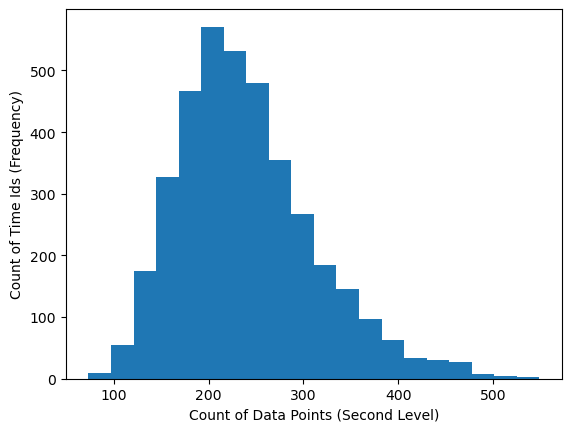

In [226]:
stock0_processed_df.head(25)

print(stock0_og_book_df.groupby('time_id').agg({'seconds_in_bucket': ['count', 'min', 'max']}))
plt.hist(stock0_og_book_df.value_counts('time_id'), bins=20)
plt.xlabel('Count of Data Points (Second Level)')
plt.ylabel('Count of Time Ids (Frequency)');

In [203]:
df_book.groupby('stock_id').agg({
    'ask_price1': ['count', 'min', 'max'],
    'wap1': ['count', 'min', 'max']
})


ask_price1                         wap1                    
              count       min       max    count       min       max
stock_id                                                            
0            917553  0.944337  1.056892   917553  0.939348  1.053275
1           1507532  0.938178  1.063606  1507532  0.937687  1.061314
2           1903140  0.964155  1.029447  1903140  0.963480  1.026931
3           1269461  0.941841  1.064984  1269461  0.939143  1.063238
4           1073989  0.952125  1.045408  1073989  0.939094  1.045292
5            981747  0.935196  1.057409   981747  0.933141  1.057227
6           1509379  0.926966  1.106601  1509379  0.926412  1.105777
7           1205965  0.980506  1.029604  1205965  0.979872  1.026969
8           1576043  0.937308  1.082591  1576043  0.936658  1.082142
9            954456  0.947088  1.041052   954456  0.944138  1.040538

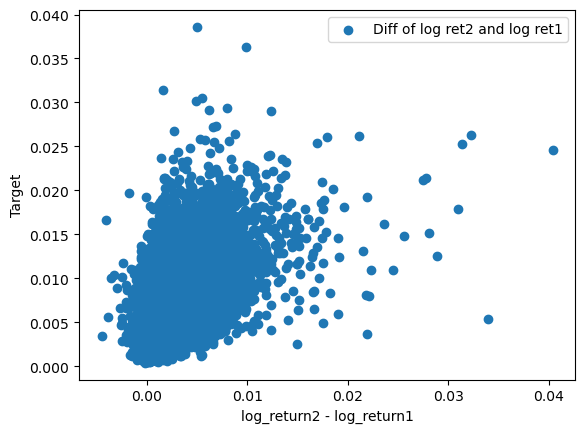

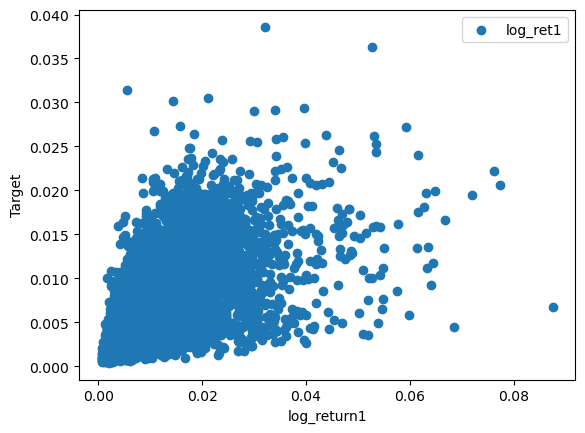

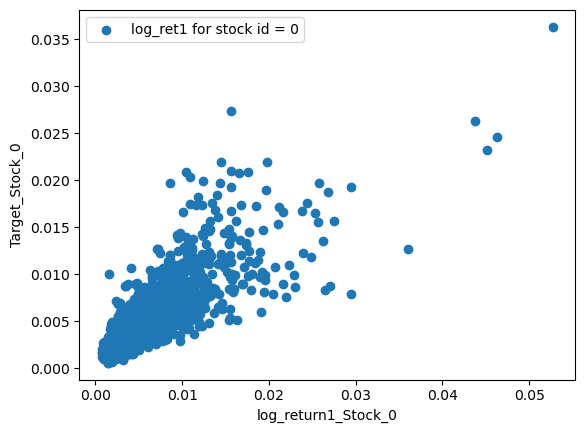

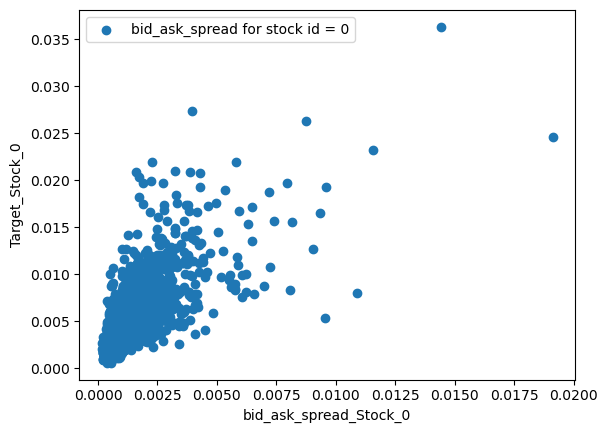

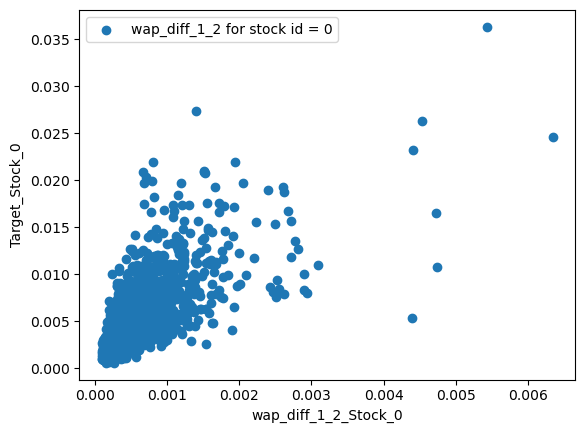

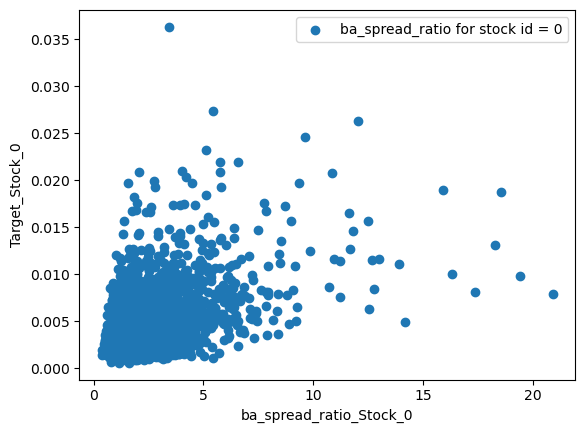

In [221]:
plt.scatter(df['log_return2'] - df['log_return1'], df['target'], label='Diff of log ret2 and log ret1')
plt.xlabel('log_return2 - log_return1')
plt.ylabel('Target')
plt.legend()
plt.show()

plt.scatter(df['log_return1'], df['target'],  label='log_ret1')
plt.xlabel('log_return1')
plt.ylabel('Target')
plt.legend()
plt.show()

plt.scatter(df[df['stock_id'] == 0]['log_return1'], df[df['stock_id'] == 0]['target'],  label='log_ret1 for stock id = 0')
plt.xlabel('log_return1_Stock_0')
plt.ylabel('Target_Stock_0')
plt.legend()
plt.show()

plt.scatter(df[df['stock_id'] == 0]['bid_ask_spread'], df[df['stock_id'] == 0]['target'],  label='bid_ask_spread for stock id = 0')
plt.xlabel('bid_ask_spread_Stock_0')
plt.ylabel('Target_Stock_0')
plt.legend()
plt.show()

plt.scatter(df[df['stock_id'] == 0]['wap_diff_1_2'], df[df['stock_id'] == 0]['target'],  label='wap_diff_1_2 for stock id = 0')
plt.xlabel('wap_diff_1_2_Stock_0')
plt.ylabel('Target_Stock_0')
plt.legend()
plt.show()

plt.scatter(df[df['stock_id'] == 0]['ba_spread_ratio'], df[df['stock_id'] == 0]['target'],  label='ba_spread_ratio for stock id = 0')
plt.xlabel('ba_spread_ratio_Stock_0')
plt.ylabel('Target_Stock_0')
plt.legend()
plt.show()

In [205]:
df[df['stock_id'] == 0]['target']

0       0.004136
1       0.001445
2       0.002168
3       0.002195
4       0.001747
          ...   
3825    0.002611
3826    0.001190
3827    0.004264
3828    0.004352
3829    0.001084
Name: target, Length: 3830, dtype: float64

rmspe_score: 0.4531507294244585


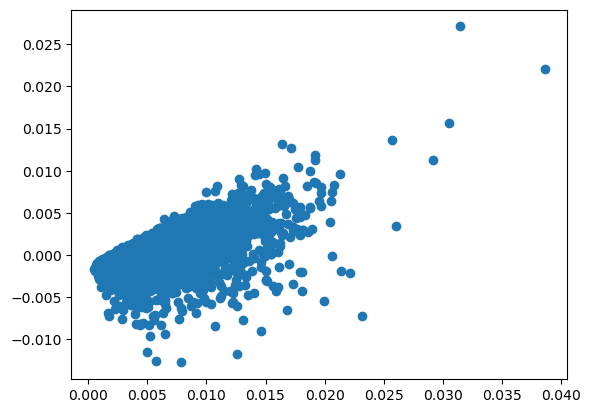

Coefficients:
stock_id             0.000050
log_return1         -0.177368
log_return2          0.368221
trade_log_return1    0.007850
wap_diff_1_2        -0.050313
bid_ask_spread       1.279846
bid_spread           0.092980
ask_spread          -0.124413
ba_spread_ratio      0.000017
dtype: float64


LinearRegression()

In [206]:
# Create a linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmspe_score = rmspe(y_test, y_pred);print('rmspe_score:',rmspe_score)


diff = y_test - y_pred

plt.scatter(y_test, diff)
plt.show()

# Get the coefficients
coefficients = pd.Series(model.coef_, index=X_test.columns)

# Print or analyze the coefficients
print("Coefficients:")
print(coefficients)
model

26810
26810
rmspe_score: 0.3473522621191017


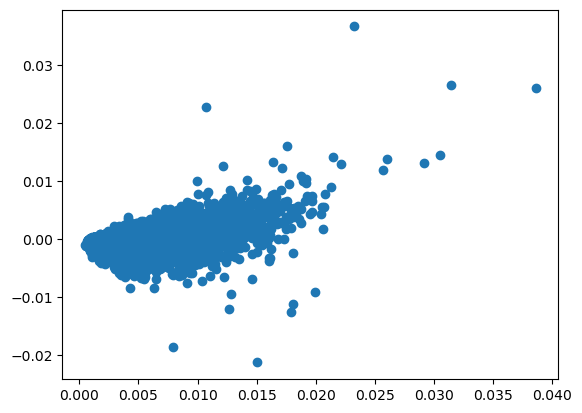

In [207]:
print(len(X_train))
print(len(y_train))

from sklearn.preprocessing import PolynomialFeatures

# Create PolynomialFeatures with degree 3
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(X_train)

# Train a linear regression model with polynomial features
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y_train)

# Visualize the results
X_new_poly = poly_features.transform(X_test)
y_pred = lin_reg.predict(X_new_poly)

X_test
rmspe_score = rmspe(y_test, y_pred);print('rmspe_score:',rmspe_score)
diff = y_test - y_pred

plt.scatter(y_test, diff)
plt.show()

In [208]:
X_test

,stock_id,log_return1,log_return2,trade_log_return1,wap_diff_1_2,bid_ask_spread,bid_spread,ask_spread,ba_spread_ratio
2681,0,0.007410,0.010356,0.016497,0.000483,0.001078,0.000149,0.000237,3.409692
2682,0,0.002438,0.005099,0.007928,0.000284,0.000576,0.000109,0.000212,2.896461
2683,0,0.002830,0.003999,0.005570,0.000202,0.000502,0.000169,0.000161,1.644867
2684,0,0.003990,0.006849,0.024715,0.000427,0.000747,0.000169,0.000218,2.492283
2685,0,0.002649,0.004264,0.014635,0.000203,0.000625,0.000098,0.000219,3.775904
...,...,...,...,...,...,...,...,...,...
38295,9,0.005344,0.007541,0.010985,0.000482,0.000996,0.000183,0.000177,2.079240
38296,9,0.003768,0.004097,0.013394,0.000307,0.000904,0.000118,0.000126,1.937813
38297,9,0.003223,0.007377,0.003399,0.000514,0.001017,0.000174,0.000459,5.917637
38298,9,0.004849,0.006573,0.019301,0.000239,0.000476,0.000129,0.000136,1.606615


In [209]:
#LGBM

# Parameters of Light GBM
params_lgbm = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'learning_rate': 0.1,
        'objective': 'regression',
        'metric': 'None',
        'max_depth': -1,
        'n_jobs': -1,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.7,
        'lambda_l2': 2,
        'verbose': 0,
        'bagging_freq': 5
}

cats = ['stock_id']


# Create dataset
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cats, weight=1/np.power(y_train,2))
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cats, weight=1/np.power(y_test,2))

# Define loss function for lightGBM training
def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

# training
model = lgb.train(params_lgbm, 
                  train_data, 
                  valid_sets=test_data, 
                  feval=feval_RMSPE
                 )

# Prediction w/ test data
y_pred = model.predict(X_test)

# RMSPE calculation
rmspe_score = rmspe(y_test, y_pred);print('rmspe_score:',rmspe_score)

# delete dataset
del train_data, test_data

print(rmspe_score)

rmspe_score: 0.2634186528166325
0.2634186528166325


In [210]:
# KNN regression model
knn_model = KNeighborsRegressor(n_neighbors=10,metric='manhattan',weights='distance')

# Fit the model on the training data
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test)

# Evaluate the model
rmspe_score = rmspe(y_test, y_pred);print('rmspe_score:',rmspe_score)

rmspe_score: 0.4361009755003729


In [211]:
#XGBoost

import xgboost as xgb

#xg_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=25, max_depth=1)
xg_model = xgb.XGBRegressor(objective="reg:absoluteerror", n_estimators=25, max_depth=1)

xg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xg_model.predict(X_test)

# Evaluate the model
rmspe_score = rmspe(y_test, y_pred);print('rmspe_score:',rmspe_score)

rmspe_score: 0.40562559782965935


In [212]:
from sklearn.svm import SVR



svm_model = SVR(
    kernel='poly',
    C=11.0,
    epsilon=0.1,
    degree=3,
    gamma='scale',
    shrinking=True,
    tol=1e-3
)

svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)
rmspe_score = rmspe(y_test, y_pred);print('rmspe_score:',rmspe_score)
print(y_test)
print(y_pred)

rmspe_score: 5.967016441988055
2681     0.004760
2682     0.002372
2683     0.002225
2684     0.003320
2685     0.001899
           ...   
38295    0.006234
38296    0.002501
38297    0.003578
38298    0.004607
38299    0.003242
Name: target, Length: 11490, dtype: float64
[0.01835247 0.01835247 0.01835247 ... 0.01835247 0.01835247 0.01835247]


In [213]:
X_train

,stock_id,log_return1,log_return2,trade_log_return1,wap_diff_1_2,bid_ask_spread,bid_spread,ask_spread,ba_spread_ratio
0,0,0.004499,0.006999,0.018342,0.000388,0.000852,0.000176,0.000151,1.556010
1,0,0.001204,0.002476,0.013301,0.000212,0.000394,0.000142,0.000135,1.788847
2,0,0.002369,0.004801,0.012161,0.000331,0.000725,0.000197,0.000198,2.421176
3,0,0.002574,0.003637,0.006728,0.000380,0.000861,0.000190,0.000108,1.445631
4,0,0.001894,0.003257,0.008359,0.000254,0.000397,0.000191,0.000109,0.680590
...,...,...,...,...,...,...,...,...,...
37146,9,0.003869,0.004584,0.011615,0.000250,0.000599,0.000077,0.000127,2.304999
37147,9,0.005828,0.008749,0.013222,0.000854,0.001229,0.000172,0.000445,7.576570
37148,9,0.003626,0.006831,0.010777,0.000449,0.000807,0.000474,0.000233,1.270351
37149,9,0.006410,0.006496,0.007784,0.000412,0.001277,0.000096,0.000137,2.635244


In [214]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def run_grid_search(model, param_grid, X_train, y_train, scoring_metric='neg_mean_squared_error', cv=5):
    """
    Run grid search cross-validation for a machine learning model.

    Parameters:
    - model: An instance of the machine learning model (e.g., RandomForestClassifier()).
    - param_grid: Dictionary with hyperparameter names as keys and lists of values as values.
    - X_train: Features of the training data.
    - y_train: Target variable of the training data.
    - scoring_metric: Scoring metric for cross-validation (default is 'neg_mean_squared_error').
    - cv: Number of cross-validation folds (default is 5).

    Returns:
    - GridSearchCV object containing the best model and results.
    """

    # Create the grid search object
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=scoring_metric)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Print the best parameters and corresponding score
    #print(f"Best Parameters: {grid_search.best_params_}")
    #print(f"Best {scoring_metric.capitalize()}: {grid_search.best_score_:.4f}")
    best_params = grid_search.best_params_
    print(best_params)
    model_eval(grid_search)

    return grid_search

In [215]:
def model_eval(grid_search, X_test = X_test, y_test = y_test):
    # Make predictions on the test set using best params
    y_pred = grid_search.predict(X_test)

    # Evaluate the model
    #mse = mean_squared_error(y_test, y_pred);print(mse)
    rmspe_score = rmspe(y_test, y_pred);print('rmspe_score:',rmspe_score)
    mspe_score = mspe(y_test, y_pred);print('mspe_score:',mspe_score)
    #rms = mean_squared_error(y_test, y_pred, squared=False);print('rms_score:',rms)


In [216]:
#XGBoost
xg_model = xgb.XGBRegressor()
param_grid = {
    'objective' : ['reg:squarederror'], 
    'n_estimators': [5, 10, 15, 20, 25, 50],
    'max_depth': range(1,6),
    'n_repeats': [5],
    'random_state' : [42,1]
}
grid_search_result = run_grid_search(xg_model, param_grid, X_train, y_train, scoring_metric='neg_mean_squared_error', cv=3)

# Make predictions on the test set using best params
#best_model = grid_search_result.best_estimator_
#y_pred_best = best_model.predict(X_test)

#best_params = grid_search_result.best_params_
#print(best_params)

# Evaluate the model
#mse = mean_squared_error(y_test, y_pred_best);print(mse)
#rmspe_score = rmspe(y_test, y_pred_best);print('rmspe_score:',rmspe_score)

{'max_depth': 4, 'n_estimators': 10, 'n_repeats': 5, 'objective': 'reg:squarederror', 'random_state': 42}
rmspe_score: 0.35370802353876624
mspe_score: 0.1251093659157004


In [232]:
#KNN
knn_model = KNeighborsRegressor()

param_grid = { 'n_neighbors': range(5,15)
              , 'metric': ['manhattan','euclidean','minkowski']
              , 'weights' : ['distance'] 
             }
grid_search_result = run_grid_search(knn_model, param_grid, X_train, y_train, scoring_metric='neg_mean_squared_error', cv=5)

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
rmspe_score: 0.4444354233343595
mspe_score: 0.19752284551439134


In [218]:
#SVR
svm_model = SVR()
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto']}
grid_search_result = run_grid_search(svm_model, param_grid, X_train, y_train, scoring_metric='neg_mean_squared_error', cv=10)

{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
rmspe_score: 5.967016441988055
mspe_score: 35.605285218955785


In [250]:
from sklearn.pipeline import make_pipeline
## The name should be exactly the same, otherwise cannot find which to specify.

param_poly = {'polynomialfeatures__degree' :  range(3,6)  }

# S2. Define estimator: use make_pipeline to combine two functions. 

pipe_poly = PolynomialFeatures()
pipe_lr = LinearRegression()
poly_reg = make_pipeline(pipe_poly , pipe_lr)

# S3. Define GridSearchCV Estimation function, then train the model

grid_poly = GridSearchCV(poly_reg, param_poly, cv =3)

#Train the model

grid_poly.fit(X_train, y_train)

y_pred = grid_poly.predict(X_test)

rmspe_score = rmspe(y_test, y_pred);print('rmspe_score:',rmspe_score)


rmspe_score: 0.348614616693855


In [249]:
best_params = grid_poly.best_params_
print(best_params)

{'polynomialfeatures__degree': 4}


In [233]:
#LightGBM  CV

params = {
    'objective': 'regression',
    'metric': 'mse',  # Mean Squared Error for regression
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,  # Maximum number of leaves in one tree
    'learning_rate': 0.05,
    'feature_fraction': 0.9,  # Randomly select a fraction of features
    'bagging_fraction': 0.8,  # Randomly select a fraction of data
    'bagging_freq': 5,  # Frequency for bagging
    'num_boost_round': 100,  # Number of boosting rounds
    'early_stopping_rounds': 10  # Early stopping to prevent overfitting
}


# Define loss function for lightGBM training
def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False



# Create dataset
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cats, weight=1/np.power(y_train,2), free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cats, weight=1/np.power(y_test,2), free_raw_data=False)

# Perform k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=12)

cv_results = lgb.cv(
    params,
    train_data,
    #valid_sets=test_data, 
    num_boost_round=1500,  # Set a large number of boosting rounds
    folds=list(kf.split(X_train)),
    #early_stopping_rounds=10
)



# Train a LightGBM model using the full training set
final_model = lgb.train(
    params,
    train_data,
    num_boost_round=len(cv_results['valid l2-mean']),
    valid_sets=[train_data, test_data],
    #verbose_eval=10 
)

# Make predictions on the test set using the trained model
y_pred = final_model.predict(X_test)


# RMSPE calculation
rmspe_score = rmspe(y_test, y_pred);print('rmspe_score:',rmspe_score)

# delete dataset
del train_data, test_data

print(rmspe_score)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 24129, number of used features: 9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 24129, number of used features: 9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 24129, number of used features: 9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead o

In [220]:
#Neural Network Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Assuming you have feature_columns and target_column defined
X = df[feature_columns]
y = df[target_column]

# Early Stopping Properties
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Build the neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))  # Linear activation for regression


# Compile the model
#model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_absolute_percentage_error')


# Train the model
model.fit(X_train_scaled, y_train, epochs=30, batch_size=16, validation_split=0.25, verbose=1, callbacks=[early_stopping])

# Make predictions on the test set
y_pred = model.predict(X_test_scaled).flatten()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse}')
rmspe_score = rmspe(y_test, y_pred);print('rmspe_score:',rmspe_score)

Epoch 1/30
1257/1257 [==============================] - 3s 1ms/step - loss: 141.2719 - val_loss: 37.8959
Epoch 2/30
1257/1257 [==============================] - 2s 1ms/step - loss: 60.1784 - val_loss: 63.4603
Epoch 3/30
1257/1257 [==============================] - 2s 1ms/step - loss: 52.1289 - val_loss: 53.7011
Epoch 4/30
1257/1257 [==============================] - 2s 1ms/step - loss: 52.1591 - val_loss: 29.5358
Epoch 5/30
1257/1257 [==============================] - 2s 1ms/step - loss: 49.5061 - val_loss: 39.5091
Epoch 6/30
1257/1257 [==============================] - 2s 1ms/step - loss: 51.9952 - val_loss: 52.6218
Epoch 7/30
1257/1257 [==============================] - 2s 1ms/step - loss: 48.6922 - val_loss: 33.2296
Epoch 8/30
1257/1257 [==============================] - 2s 1ms/step - loss: 50.1621 - val_loss: 93.6197
Epoch 9/30
1257/1257 [==============================] - 2s 2ms/step - loss: 51.1889 - val_loss: 34.4363
Epoch 10/30
1257/1257 [==============================] - 2s 1ms